# Fluxonium-transmon gates
We study different schemes for two-qubit gates between fluxonium and transmon. 

In [1]:
import numpy as np
import sys
import qutip as qtp 
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import Image
import time

The gates will be based on the following driven Hamiltonian of capacitively coupled fluxonium and transmon

$$H = H_F + H_T + V + H_{drive}$$,

where we have the fluxonium Hamiltonian

$$H_L= 4 E_{C,F} \hat{n}^2_F + \frac{1}{2}E_{L} \hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \varphi_{ext,F}\right), \quad [\hat{\varphi}_F, \hat{n}_F] = i$$,

the transmon Hamiltonian (treated immediately as a Duffing oscillator)

$$H_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b}$$,

where in terms of the transmon's charging energy $E_{C,T}$ and Josephson energy $E_{J, T}$ the transmon's angular velocity $\omega_T$ and anharmonicity $\delta_T$ are

$$ \omega_T = \frac{\sqrt{8 E_{C, T} E_{J, T}}}{\hbar}, \quad \delta_T = - \frac{E_{C,T}}{\hbar} $$.
In addition, the transmon's charge operator can be written as
$$ \hat{n}_T = \frac{i}{2} \biggl( \frac{E_{J, T}}{2 E_{C, T}} \biggr)^{1/4} \bigl( \hat{b}^{\dagger} - \hat{b} \bigr) = \frac{i}{2} \sqrt{\frac{\omega_T}{4 \lvert \delta_T \rvert} }\bigl( \hat{b}^{\dagger} - \hat{b} \bigr).$$

The coupling Hamiltonian is

$$V = J_C  \hat{n}_F \hat{n}_T$$,

and the drive Hamiltonian

$$H_{drive} = 2  f\left( t \right)  \cos \left( \omega_d t + \gamma_d\right) \left( \eta_F  \hat{n}_F + \eta_T \hat{n}_T \right)   \text{  with  } f\left( t \right) = f_0 \dfrac{f\left( t \right)}{f_0}. $$

# 1. Gate a la Ficheux 2020

Let us introduce the two qubits. We consider a transmon with fundamental frequency $\omega_T/2 \pi = 5.0 \, \mathrm{GHz}$ and anharmonicity $\delta_T/2 \pi = - 300 \, \mathrm{MHz}$.

In [2]:
# Fluxonium parameters (like Qubit A in Ficheux 2020): values in GHz (divided by h)
ec_f = 0.973 
el_f = 0.457 
ej_f = 5.899
# ec_f = 1.027 
# el_f = 0.684 
# ej_f = 5.768
flux_f = 1/2
n_fock_f = 100
# Transmon parameters: values in GHz divided by 2 \pi 
omega_t_a = 5.0 
delta_t_a = -0.3
n_fock_t = 3

Let us introduce the two qubit objects

In [3]:
levels_f = 5
levels_t = n_fock_t
flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=n_fock_f)
trans_a = pysqkit.qubits.SimpleTransmon('TA', omega_t_a, delta_t_a, dim_hilbert=n_fock_t)
flx.diagonalize_basis(levels_f)
# The Simple Transmon is already diagonal

In [4]:
energies_f, eig_states_f = flx.eig_states(levels_f)
energies_t_a, eig_states_t_a = trans_a.eig_states(levels_t)
print('Fluxonium')
for k in range(0, 3):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^(F) = ' + str(energies_f[k + 1] - energies_f[k]) + ' GHz' )
print('------')
print('Transmon')
print('------')
print('f_01^(T) = ' + str(energies_t_a[1] - energies_t_a[0]) + ' GHz' )
print('f_12^(T) = ' + str(energies_t_a[2] - energies_t_a[1]) + ' GHz' )


Fluxonium
------
f_01^(F) = 0.06987744707831733 GHz
------
f_12^(F) = 5.1850776685159685 GHz
------
f_23^(F) = 0.9905236831630582 GHz
------
Transmon
------
f_01^(T) = 5.0 GHz
f_12^(T) = 4.699999999999999 GHz


I notice a small discrepancy of the fluxonium frequency compared to Ficheux 2020. This was not happening in the Nesterov 2020 paper. 

In [5]:
# Matrix elements
print('Fluxonium')
for k in range(0, 2):
    print('------')
    print('|n_{F,' + str(k) + str(k + 1) + '}| = ' + \
          str(np.abs(get_mat_elem(flx.charge_op(), eig_states_f[k], eig_states_f[k + 1]))))
print('------')
print('Transmon A')
for k in range(0, 2):
    print('------')
    print('|n_{T,' + str(k) + str(k + 1) + '}| = ' + \
          str(np.abs(get_mat_elem(trans_a.charge_op(), eig_states_t_a[k], eig_states_t_a[k + 1]))))
print('------')
print('\sqrt{2}|n_{T,' + str(0) + str(1) + '}| = ' + \
          str(np.sqrt(2)*np.abs(get_mat_elem(trans_a.charge_op(), eig_states_t_a[0], eig_states_t_a[1]))))
print('------')


Fluxonium
------
|n_{F,01}| = 0.025305578156298303
------
|n_{F,12}| = 0.59810178371091
------
Transmon A
------
|n_{T,01}| = 1.0507933510765408
------
|n_{T,12}| = 1.4860462083439172
------
\sqrt{2}|n_{T,01}| = 1.4860462083439172
------


Notice the $\sqrt{2}$ factor for the matrix elements of the transmon. The $n_{F,12}$ matrix element of the fluxonium is approximately half the $n_{T, 01}$ of the transmon. Thus, I expect a possible CPHASE-like gate to take twice the time as between two similar transmons. However, this is of course dependent on the transmon parameters.
We can also visualize the matrix elements as

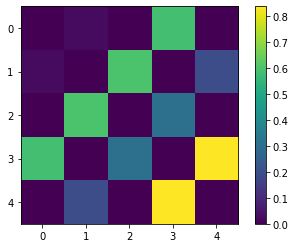

In [6]:
mat_elems_f = flx.mat_elements(operator='charge_op', levels=levels_f)
plt.imshow(np.abs(mat_elems_f))
plt.colorbar()
plt.show()

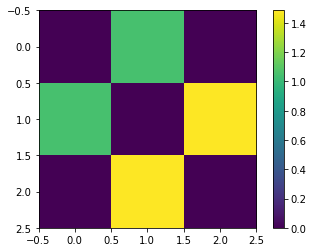

In [7]:
mat_elems_t_a = trans_a.mat_elements(operator='charge_op', levels=levels_t)
plt.imshow(np.abs(mat_elems_t_a))
plt.colorbar()
plt.show()

In the following we plot the energy levels structure. The colors represent the strength of the matrix elements of the charge operators for each transition. 

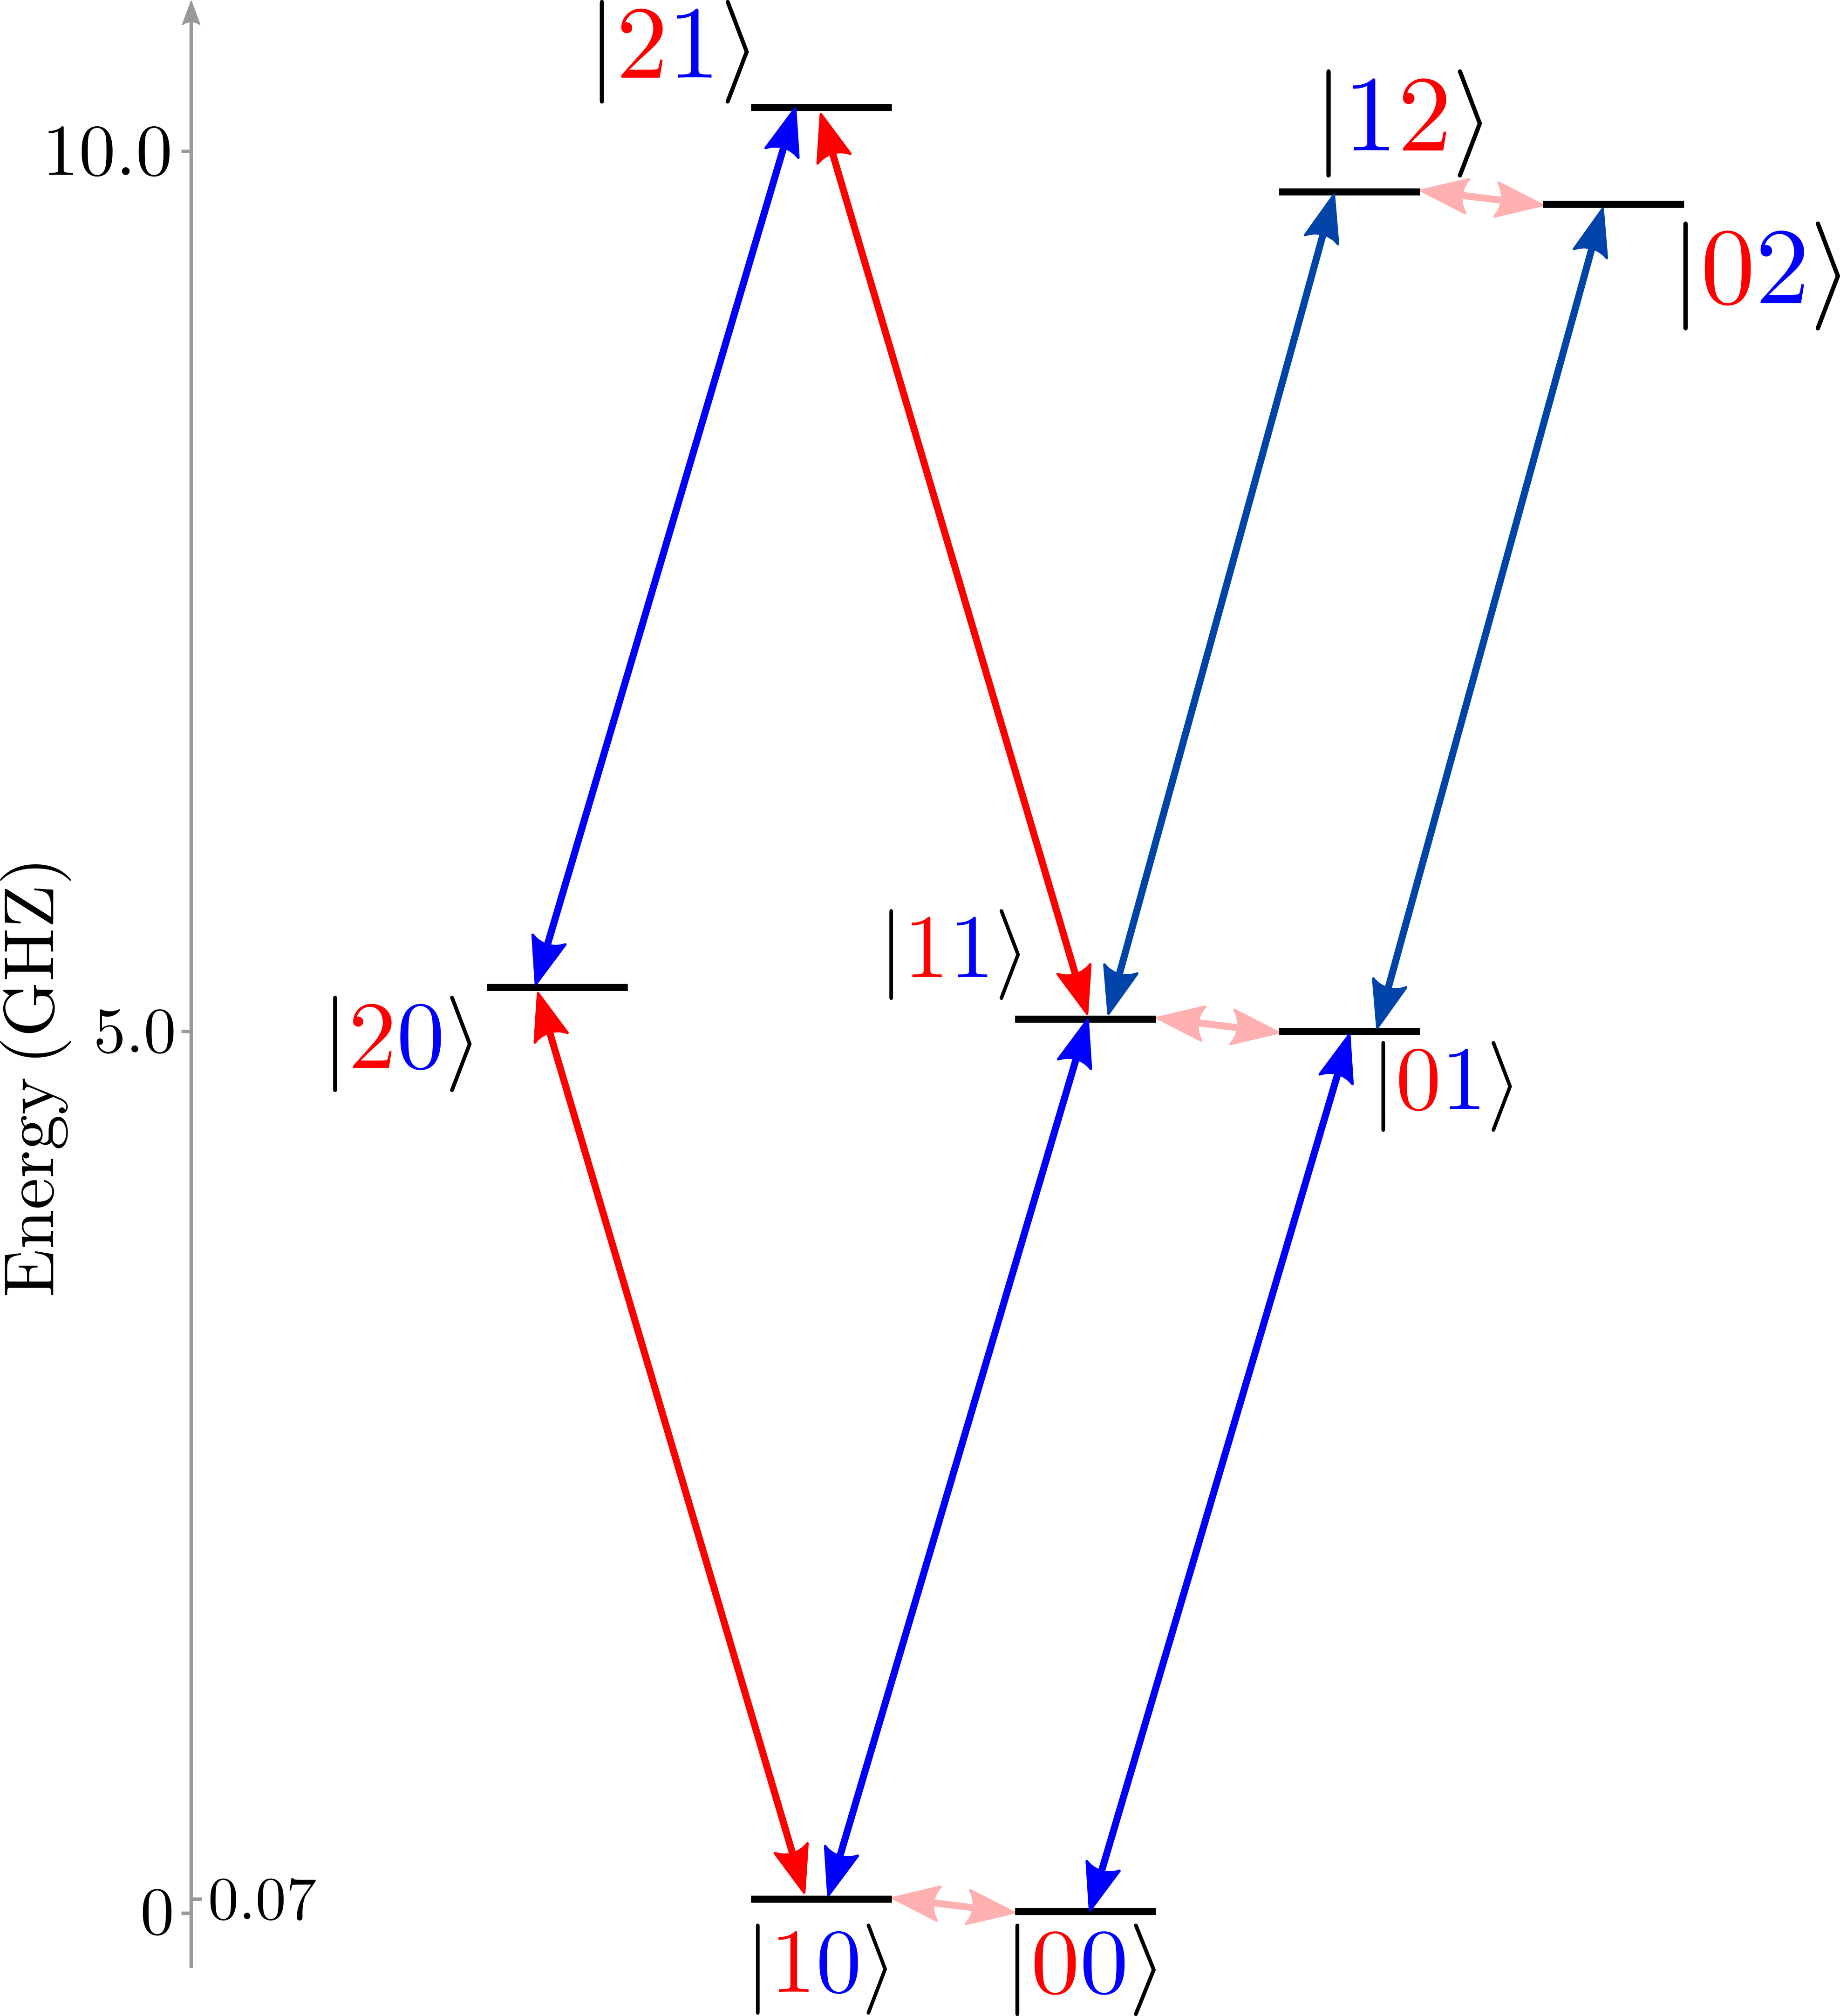

In [8]:
Image("transmon_fluxonium_levels.png", width = 400)

The previous parameters are not too smart for implementing the Ficheux gate. In fact $\lvert 11 \rangle$ and $\lvert 20 \rangle$ are very close to each other which could result in a high hybridization of the bare levels. This effect could however be exploited in a CPHASE gate. Let us evaluate the hybridization by solving the coupled eigensystem. The energies of the uncoupled system are

In [9]:
bare_energies_fta = np.zeros(levels_f*n_fock_t, dtype=float)
count = 0
for k in range(0, levels_f):
    for m in range(0, n_fock_t):
        bare_energies_fta[count] = energies_f[k] + energies_t_a[m] 
        count += 1
label_converter_a = np.argsort(bare_energies_fta)

def labels_to_energy(
    lev_f: int, 
    lev_t: int, 
    energies: np.ndarray, 
    label_converter: np.ndarray,
    n_levels_f=levels_f, 
    n_levels_t=n_fock_t, 
) -> float:
    if lev_t >= n_levels_t:
        raise ValueError("Transmon has to be smaller than the total number of transmon levels")
    if lev_f >= n_levels_f:
        raise ValueError("Fluxonium has to be smaller than the total number of fluxonium levels")
    label = lev_f*n_levels_t + lev_t
    index = np.where(label_converter==label)[0][0]
    return energies[index]

def labels_to_state(
    lev_f: int, 
    lev_t: int, 
    eig_states: np.ndarray, 
    label_converter: np.ndarray,
    n_levels_f=levels_f, 
    n_levels_t=n_fock_t, 
) -> float:
    if lev_t >= n_levels_t:
        raise ValueError("Transmon has to be smaller than the total number of transmon levels")
    if lev_f >= n_levels_f:
        raise ValueError("Fluxonium has to be smaller than the total number of fluxonium levels")
    label = lev_f*n_levels_t + lev_t
    index = np.where(label_converter==label)[0][0]
    return eig_states[index]

In [10]:
jc = 0.224 # GHz same as in Ficheux 2020
flx_trans_a = flx.couple_to(trans_a, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_fta, eigstates_fta = flx_trans_a.eig_states()

We conveniently introduce two-dimensional np.ndarray to store the energies so that they can be easily accessed

In [11]:
bare_energy_mat = np.zeros([levels_f, levels_t], dtype=float)
energy_mat = np.zeros([levels_f, levels_t], dtype=float)
for lev_f in range(0, levels_f):
    for lev_t in range(0, levels_t):
        bare_energy_mat[lev_f, lev_t] = labels_to_energy(lev_f, lev_t, np.sort(bare_energies_fta), 
                                                         label_converter_a)
        energy_mat[lev_f, lev_t] = labels_to_energy(lev_f, lev_t, energies_fta, label_converter_a)

We can check that the function labels_to_energy correctly gives the adiabatic continuation of the level. In fact, we expect the energies to be close to the bare ones.

In [12]:
lev_f = 1
lev_t = 2
print("------")
print("E_" + str(lev_f) + str(lev_t) + "^(bare) = " + str(bare_energy_mat[lev_f, lev_t]) + " GHz")
print("------")
print("E_" + str(lev_f) + str(lev_t) + " = " + str(energy_mat[lev_f, lev_t]) + " GHz")

------
E_12^(bare) = 9.138672077096846 GHz
------
E_12 = 9.066871294447479 GHz


We can check that $\lvert 11 \rangle$ and $\lvert 20 \rangle$ show high hybridization. In fact

In [13]:
print("E_{20, bare}/h = " + str(bare_energy_mat[2, 0]) + ' GHz')
print("E_{20}/h = " + str(energy_mat[2, 0]) + ' GHz')
print('------')
print("E_{11, bare}/h = " + str(bare_energy_mat[1, 1]) + ' GHz')
print("E_{11}/h = " + str(energy_mat[1, 1]) + ' GHz')
print('------')

E_{20, bare}/h = 4.623749745612815 GHz
E_{20}/h = 4.697867855866869 GHz
------
E_{11, bare}/h = 4.438672077096847 GHz
E_{11}/h = 4.358865433890758 GHz
------


To further evaluate the hybridization let us print the amplitudes of the corresponding eigenkets

In [14]:
print("|20>")
print(labels_to_state(2, 0, eigstates_fta, label_converter_a))
print('------')
print("|11>")
print(labels_to_state(1, 1, eigstates_fta, label_converter_a))

|20>
[-8.09504173e-04-0.j  6.77929934e-15+0.j -1.39576482e-03+0.j
 -4.37079728e-16+0.j -4.70223412e-01+0.j -1.61800277e-16+0.j
 -8.82404057e-01+0.j  1.98087056e-16+0.j -9.60873693e-03+0.j
 -8.57900810e-16+0.j -1.09763631e-02+0.j -9.87011754e-18+0.j
  5.62578713e-03+0.j  2.40526433e-16+0.j -2.44159224e-03+0.j]
------
|11>
[ 9.07520242e-04+0.j -3.16066617e-14+0.j  1.35976434e-03+0.j
 -1.02491241e-16+0.j  8.82242580e-01+0.j -1.84139300e-17+0.j
 -4.70333690e-01+0.j -3.35867138e-16+0.j  1.76809283e-02+0.j
 -2.56890315e-15+0.j -5.26932441e-03+0.j  3.56597056e-16+0.j
 -8.68502459e-03+0.j -5.40753468e-16+0.j  3.97064332e-03+0.j]


Again the hybridization is visible. This suggests to take different parameters for this gate. In this setup the residual $ZZ$ coupling is

In [15]:
def zz(energy_mat):
    return energy_mat[1, 1] + energy_mat[0, 0] - energy_mat[1, 0] - energy_mat[0, 1]

zz_coup_a = zz(energy_mat)
print('\\xi_ZZ/h = ' +str(zz_coup_a) + ' GHz')

\xi_ZZ/h = -0.060804297323113765 GHz


In addition, the $J_C$ parameter seems much larger than its typical value in transmon qubits. This is because it was designed for two fluxonia that have very small matrix elements of the charge operator. Taking the same value and assuming two equal transmons this would result in a $J_1$ coupling

In [16]:
j1_eq_trans = jc*np.abs(get_mat_elem(trans_a.charge_op(), eig_states_t_a[0], eig_states_t_a[1]))**2
print("J1 assuming two transmons: " + str(j1_eq_trans) + ' GHz')

J1 assuming two transmons: 0.24733333333333327 GHz


This is an order of magnitude larger than the $J_1$ in the DiCarlo lab that is usually $10-15 \, \mathrm{MHz}$. 
Assuming two fluxonia the $J_1$ coupling would instead be

In [17]:
j1_eq_flx = jc*np.abs(get_mat_elem(flx.charge_op(), eig_states_f[0], eig_states_f[1]))**2
print("J1 assuming two fluxonia: " + str(j1_eq_flx) + ' GHz')

J1 assuming two fluxonia: 0.0001434433920246929 GHz


Thus way smaller. 
The Ficheux gate is based on the fact that the frequency of the $\lvert 10 \rangle - \lvert 20 \rvert$ transition is different than the frequency of the $\lvert 11 \rangle - \lvert 21 \rvert$ transition. In particular, this frequency difference
$$
\Delta = \frac{\lvert (E_{20} - E_{10}) - (E_{21} - E_{11}) \rvert}{h},
$$
sets the gate time simply as $t_{\mathrm{gate}} = 1/\Delta $

In [18]:
def delta_ficheux(energy_mat):
    return (energy_mat[2, 0] - energy_mat[1, 0]) - (energy_mat[2, 1] - energy_mat[1, 1])
delta_f = delta_ficheux(energy_mat)
print("Delta = " + str(delta_f) + " GHz")

Delta = -0.0758946996208838 GHz


In the following we will proceed in the following way. We keep $J_C$ fixed and we vary the transmon frequency to look for a candidate frequencies where the ration between the parameter $\Delta$ in Ficheux and the ZZ coupling is large.

## Varying the frequency of the transmon

In [40]:
n_points = 1000
omega_vec = np.linspace(3.5, 7.0, n_points)
zz_coup_vec = np.zeros(n_points, dtype=float)
delta_f_vec = np.zeros(n_points, dtype=float)
jc_new = 0.2*jc

In [41]:
start = time.time()

for i in range(0, n_points):
    trans = pysqkit.qubits.SimpleTransmon('T', omega_vec[i], delta_t_a, dim_hilbert=n_fock_t)
    energies_t, eig_states_t = trans.eig_states(levels_t)
    flx_trans = flx.couple_to(trans, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_new)
    energies, eigstates = flx_trans.eig_states()
    bare_energies = np.zeros(levels_f*n_fock_t, dtype=float)
    count = 0
    for k in range(0, levels_f):
        for m in range(0, n_fock_t):
            bare_energies[count] = energies_f[k] + energies_t[m] 
            count += 1
    label_converter = np.argsort(bare_energies)
    en_mat = np.zeros([levels_f, levels_t], dtype=float)
    for lev_f in range(0, levels_f):
        for lev_t in range(0, levels_t):
            en_mat[lev_f, lev_t] = labels_to_energy(lev_f, lev_t, energies, label_converter)
    zz_coup_vec[i] = zz(en_mat)
    delta_f_vec[i] = delta_ficheux(en_mat)    

end=time.time()

print("Computation time: " + str(end - start) + ' s')

Computation time: 9.861248016357422 s


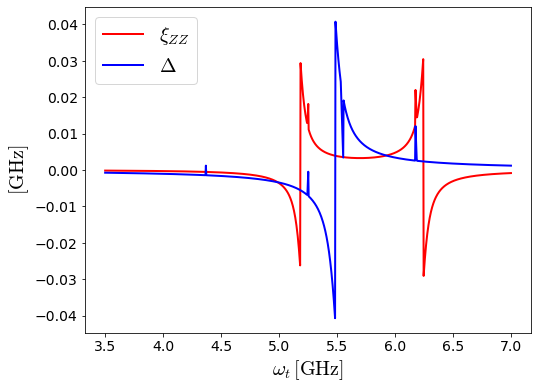

In [42]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
def plot_zz_delta(
    omega_vec: np.ndarray,
    zz_coup_vec: np.ndarray,
    delta_f_vec: np.ndarray,
    opt: dict
) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(omega_vec, zz_coup_vec, linewidth=opt['lw'], color='red', label='$\\xi_{ZZ}$')
    ax.plot(omega_vec, delta_f_vec, linewidth=opt['lw'], color='blue', label='$\Delta$')
    ax.axes.set_xlabel("$\omega_t \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.legend(fontsize=opt['fs'])
    plt.show()
    
plot_zz_delta(omega_vec, zz_coup_vec, delta_f_vec, plot_setup)   
    

From the plot I conclude that there is no clear point where there is a separation between the $ZZ$ coupling and the $\Delta$ parameter in the Ficheux paper. The gate will have to deal with a ZZ coupling whose strength is comparable to the parameter that controls the gate speed. This makes the protocol unappealling for transmon-fluxonium two-qubit gates.

# 2. CPHASE gate via flux tuning the transmon

In [42]:
jc*np.abs(get_mat_elem(flx.charge_op(), eig_states_f[0], eig_states_f[1]))**2

0.0001434433920246929

In [35]:
np.abs(get_mat_elem(trans.charge_op(), eig_states_t[0], eig_states_t[1]))

1.0507933510765408

In [58]:
ec_fb = 1.027
el_fb = 0.684
ej_fb = 5.768
flx_b = pysqkit.qubits.Fluxonium('FB', ec_fb, el_fb, ej_fb, flux_f, dim_hilbert=n_fock_f)
flx_b.diagonalize_basis(levels_f)
energies_fb = flx_b.eig_energies()
flx_flxb = flx.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_ff, eig_states_ff = flx_flxb.eig_states()

In [59]:
bare_energies_ff = np.zeros(levels_f**2, dtype=float)
count = 0
for k in range(0, levels_f):
    for m in range(0, levels_f):
        bare_energies_ff[count] = energies_f[k] + energies_fb[m] 
        count += 1
label_converter_ff = np.argsort(bare_energies_ff)

In [62]:
energy_ff_mat = np.zeros([levels_f, levels_f], dtype=float)
for lev_f in range(0, levels_f):
    for lev_fb in range(0, levels_f):
        energy_ff_mat[lev_f, lev_fb] = labels_to_energy(lev_f, lev_fb, energies_ff, 
                                                     label_converter_ff, n_levels_f=levels_f, n_levels_t=levels_f)

In [63]:
delta_ficheux = (energy_ff_mat[2, 0] - energy_ff_mat[1, 0]) - (energy_ff_mat[2, 1] - energy_ff_mat[1, 1])

In [64]:
delta_ficheux

-0.025469601201645986